# Prueba de clasificación embbeddings con espectros.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from nltk.tokenize import word_tokenize
import nltk
import we_to_signal as wes

[nltk_data] Downloading package punkt to /home/ulises/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ulises/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Con los poemas separados, los metemos en un diccionario de dataframes
import os

data_path = "data/"
emotion_list = ["anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust"]

json_files = sorted([pos_json for pos_json in os.listdir(data_path) if pos_json.endswith('.json')])
json_files.remove('Poems.json')
json_files.remove('missing.json')

em_poems = {}
for e in emotion_list:
    f = open(data_path+e+".json")
    df_ = pd.DataFrame(json.load(f))
    em_poems[e] = df_
em_poems["anger"]

,poem,id
0,i do know this it's nothing i can hold\nlast ...,10
1,the fear o' hell's a hangman's whip\nto haud t...,18
2,but since i laid a hand thereon\nand found a h...,88
3,falsely i pointed to sum in text\nseriously he...,99
4,i'll wear my jealous reflection\njuice of lemo...,125
...,...,...
2461,new snow on a leaf\nlike granulated sugar\nmak...,93124
2462,new earth and old earth\na trio of guardians\n...,93138
2463,destructions despair\nconstructions hope toge...,93217
2464,hot dry summers will\nbake paint right off the...,93226


In [3]:
#Carga de embeddings
from gensim.models import Word2Vec
from gensim.models import FastText

emotion_list = ["anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust"]

poems_w2v = {}
poems_fst = {}

for e in emotion_list:
    w2v_lines = Word2Vec.load("embeddings_poems/w2v_model_"+e)
    fst_lines = FastText.load("embeddings_poems/fst_model_"+e)
    poems_w2v[e] = w2v_lines
    poems_fst[e] = fst_lines

In [6]:
from nltk.corpus import stopwords

set_ = set()
for emotion in emotion_list:
    fst = set(poems_fst[emotion].wv.key_to_index.keys())
    w2v = set(poems_w2v[emotion].wv.key_to_index.keys())
    intersection = fst & w2v
    if not set_:
        set_ = set_.union(intersection)
    else:
        set_ = set_.intersection(intersection)

stop_words = set(stopwords.words('english'))
set_ = set_ - stop_words
len(set_)

562

In [7]:
from collections import Counter

def get_word_freq(dataframe:pd.DataFrame,col:str,emotion_list:list):
    """
    Calculates for Counter model of each emotion text corpus.

    Parameters
    ------------
    dataframe: pandas Dataframe with documents.
    col:str name of the column where the documents are.
    emotion_list: list with emotions

    Returns
    -----------
    dict:
        dictionary with keys(emotions_list) an each key with his self Counter model.
    """
    freq_dict = {}
    for emotion in emotion_list:
        tokens = dataframe[emotion][col].apply(lambda x: [token for token in word_tokenize(x)])
        l1 = tokens.values.tolist()
        l2 = [w for l in l1 for w in l ]
        freq_dict[emotion] = Counter(l2)
    return freq_dict

In [8]:
def text_clean(sent):
    import re
    from unidecode import unidecode
    import unicodedata as ud

    d = {ord('\N{combining acute accent}'):None}
    sent = ud.normalize('NFD',sent).translate(d)
    sent = re.sub(r"[^\w .,;?!\n]+", "", sent)
    sent = re.sub(r"[^\w .,;?!]", " ", sent)
    sent = re.sub(r"[^\w .,]", ".", sent)
    sent = re.sub(r"[^\w ]", "", sent)
    sent = re.sub(r"[0-9]", "", sent)
    sent = re.sub(r"[α-ωςϑϕϜϝϞϠϰϱ]", "", sent)
    sent = re.sub(r"[ΓΔΕΖΗΘΙΚΛΜΝΞΟΠΡΣΤΥΦΧΨΩ]", "", sent)
    sent = re.sub(r"[A-Z]{2}", "", sent)
    return sent

In [10]:
em_poem_c = dict()

for emotion in emotion_list:
    em_poem_c[emotion] = em_poems[emotion].copy()

for emotion in emotion_list:
    em_poem_c[emotion]["poems_clean"] = em_poem_c[emotion]["poem"].apply(text_clean)

freq_dict = get_word_freq(em_poem_c,"poems_clean",emotion_list)

In [11]:
from itertools import combinations
from scipy.stats import pearsonr

def get_words_info(model,set_,freq_dict):
    emotion_combinations = list(combinations(emotion_list,2))

    words_embbed_info = {}
    words_embbed_info["words"] = list(set_)

    for emotion in emotion_list:
        words_embbed_info["f_"+emotion] = []

    for comb in emotion_combinations:
        words_embbed_info["P_"+str(comb)] = []

    for word in set_:
        #Añadimos la frecuencia por cada emoción
        for emotion in emotion_list:
            words_embbed_info["f_"+emotion].append(freq_dict[emotion][word])

        #Calculamos la correlacion pearson para cada par de emociones.    
        for comb in emotion_combinations:
            emotion_a = comb[0]
            emotion_b = comb[1]

            words_embbed_info["P_"+str(comb)].append(pearsonr(model[emotion_a].wv.get_vector(word,norm=True),model[emotion_b].wv.get_vector(word,norm=True)))
        
    words_embbed = pd.DataFrame(words_embbed_info)
    return words_embbed

In [15]:
words_embbed_w2v_info = get_words_info(poems_w2v,set_,freq_dict)

In [18]:
words_embbed_fst_info = get_words_info(poems_fst,set_,freq_dict)

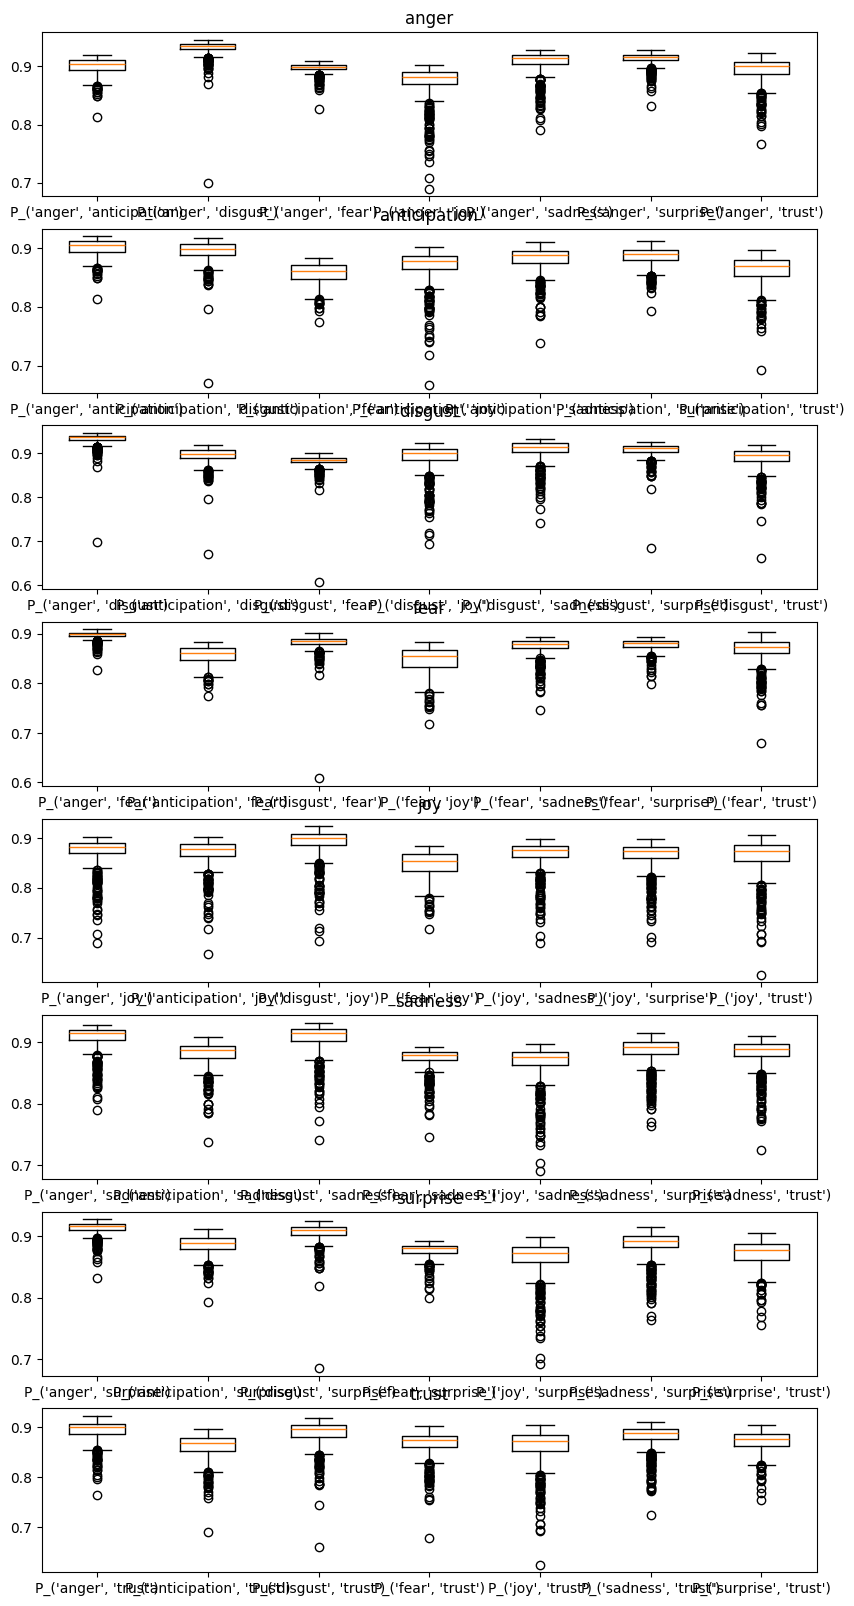

In [39]:
fig,ax = plt.subplots(8,figsize=(10,20))
columns = words_embbed_w2v_info.columns
i = 0
for emotion in emotion_list:
    data = []
    labels = []
    for column in columns:
        if emotion in column:
            if 'f_' in column:
                continue
            data.append([element[0] for element in words_embbed_w2v_info[column]])
            labels.append(column)
    ax[i].boxplot(data)
    ax[i].set_xticklabels(labels)
    ax[i].set_title(emotion)
    i+=1

In [190]:
from memspectrum import MESA

word = poems_fst["disgust"].wv.get_vector("died",norm=True)

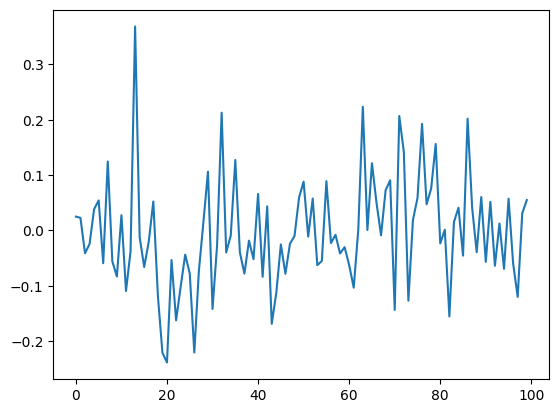

In [193]:
plt.plot(poems_fst["disgust"].wv.get_vector("cold",norm=True))

In [197]:
from scipy.stats import pearsonr
pearsonr(poems_fst["disgust"].wv.get_vector("cold"),poems_fst["disgust"].wv.get_vector("clay"))

PearsonRResult(statistic=0.9999279514231302, pvalue=4.770873631407636e-190)

In [194]:
#Calculamos los embeddigs separando por emociones 
poems_w2v = {}
poems_fst = {}
for e in emotion_list:
    df = em_poems[e]
    mw2v_poems = wes.compute_embeddings(df, embed="w2v", columna_docs='poem', vec_dim=100)
    mfst_poems = wes.compute_embeddings(df, embed="fst", columna_docs='poem', vec_dim=100)
    poems_w2v[e] = mw2v_poems
    poems_fst[e] = mfst_poems